In [3]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
#import libraries

import os
import math
import cv2
import struct
import glob
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import xml.etree.ElementTree as ET

In [5]:
PROCESSED_DATA = './ICDAR/ICDAR_Processed'
IMAGE_PATH = os.path.join(PROCESSED_DATA, 'image')
TABLE_MASK_PATH = os.path.join(PROCESSED_DATA, 'table_mask')
COL_MASK_PATH = os.path.join(PROCESSED_DATA, 'col_mask')
ORIG_DATA_PATH = '.\ICDAR\ICDAR2019_cTDaR/training\TRACKB1\ground_truth'

In [ ]:
os.makedirs(PROCESSED_DATA, exist_ok = True)
os.makedirs(IMAGE_PATH, exist_ok = True)
os.makedirs(TABLE_MASK_PATH, exist_ok = True)
os.makedirs(COL_MASK_PATH, exist_ok = True)

In [ ]:
import xml.etree.ElementTree as ET
tree = ET.parse('cTDaR_t00005.xml')
root = tree.getroot()

In [6]:
# Function to set a value in the table
def set_value(table, row, col, value):
    table[(row, col)] = value

# Function to get a value from the table
def get_value(table, row, col):
    return table.get((row, col), None)

# Point Extraction from XMLS

### Extraction and arrangement of points for columns from XMLs

In [7]:
import math
def parrange(start_row, start_col, end_row, end_col, pointsfornow, points):
  if(end_row == None):
    end_row = start_row
  if(end_col == None):
    end_col = start_col
  rows = end_row - start_row + 1
  cols = end_col - start_col + 1
  if(rows == 1 and cols == 1):
    set_value(pointsfornow, start_row, start_col, points[0:4])
    set_value(pointsfornow, start_row, start_col, [points[0], points[1], points[math.floor((len(points)-2)/2)+1], points[math.floor((len(points)-2)/2)+2]])
  elif (rows != 1 or cols != 1) and len(points) > 4:
    left = points[:rows+1]
    top = points[rows+1:rows+cols]
    right = points[rows+cols:rows+cols+rows+1]
    bottom = points[rows+cols+rows+1:]
    right.reverse()
    bottom.reverse()
    pts1 = True if len(points) == 2*(rows+cols) else False
    L1 = True if len(left) == rows+1 else False
    R1 = True if len(left) == rows+1 else False
    T1 = True if  len(top) == cols-1 else False
    B1 = True if  len(bottom) == cols-1 else False
    master = True if pts1 and L1 and R1 and T1 and B1 else False
    for row in range(rows):
      for col in range(cols):
        if col == 0 and cols > 1 and master and len(top)>0:
          set_value(pointsfornow, start_row+row, start_col+col, [left[row], left[row+1], top[col], bottom[col]])
        elif col == cols-1 and master and len(top)>0:
          set_value(pointsfornow, start_row+row, start_col+col, [bottom[col-1], top[col-1], right[row], right[row+1]])
        elif col > 0 and col < cols-1 and master and len(top)>0:
          set_value(pointsfornow, start_row+row, start_col+col, [bottom[col-1], top[col-1], top[col], bottom[col]])
        else:
          set_value(pointsfornow, start_row+row, start_col+col, None)

In [8]:
def string_to_points(coord_string):
    points = coord_string.split()
    return [tuple(map(int, point.split(','))) for point in points]

In [9]:
def getall(root):
  table= []
  all_points = []
  max_col = []  # Variable to track the maximum end-col value

  for child in root: #Tables in Document
      pointsfornow = {}
      mxc = 0
      for child2 in child: #coord for table and cell in Table
        if 'points' in child2.attrib:
              table.append(string_to_points(child2.attrib['points']))
        else:
            start_row, start_col, end_row, end_col = None, None, None, None
            try:
              start_row = int(child2.attrib['start-row'])
              start_col = int(child2.attrib['start-col'])
              end_row = int(child2.attrib['end-row'])
              end_col = int(child2.attrib['end-col'])
            except(ValueError, TypeError):
              print("exception in Start/End Row/Column")
            try:
              if end_col > mxc:
                mxc = end_col
            except (ValueError, TypeError):
              print("exception in max col")
              if start_col > mxc:
                mxc = start_col
        for child3 in child2: #coord in Cell within Table
          if 'points' in child3.attrib:
                  parrange(start_row, start_col, end_row, end_col, pointsfornow, string_to_points(child3.attrib['points']))
      all_points.append(pointsfornow)
      max_col.append(mxc+1)
  return table, all_points, max_col 

## THIS is for COLUMN MASK ONLY

In [10]:
def customsort(points):
  toreturn = []
  for unsorted_dict in points:
    sorted_dict = dict(sorted(unsorted_dict.items(), key=lambda item: (item[0][0], item[0][1])))
    toreturn.append(sorted_dict)
  return toreturn

In [25]:
def toplot(all_ps, max_col):
    ret = []
    for p, all_poins in enumerate(all_ps):
      temp_ret = []
      resultant = list(all_poins.items())[-max_col[p]:]
      replacefrm = list(all_poins.items())[:max_col[p]]

# Iterate through the dictionary keys
      resultant = dict(resultant)
      replacefrm = dict(replacefrm)
      R1 = 0
      for key1 in resultant.keys():
        A = key1[0]
        if A > R1:
          R1 = A
      R2 = 1234567890123456789012345678901234567890
      for key2 in replacefrm.keys():
        B = key2[0]
        if B < R2:
          R2 = B
      print(resultant)
      print(replacefrm)
      print(max_col[p], len(resultant), len(replacefrm))
      for i in range(max_col[p]):
        # j, k = 1, 1
        # res, rep = resultant[(R1, i)],  replacefrm[(R2, i)]
        j, k = 0, 0
        res, rep = None, None
        while res == None:
          print("j:", j,"R1:", R1, all_poins[(R1 - j, i)])
          res= all_poins[(R1 - j, i)]
          j = j+1
          # if(R1-j<0):
          #   res= False
        while rep == None:
          # print("k:", k,"R2:", R2)
          rep = all_poins[(R2 + k, i)]
          k = k+1
          # if(R1+k>R1):
          #   rep= False
        # if(rep != False and res != False):
        res[0] = rep[0]
        res[3] = rep[3]
        res[0], res[1], res[2], res[3] = list(res[0]), list(res[1]), list(res[2]), list(res[3])
        res[0][0] += 20
        res[1][0] += 20
        res[2][0] -= 20
        res[3][0] -= 20
        res[0], res[1], res[2], res[3] = tuple(res[0]), tuple(res[1]), tuple(res[2]), tuple(res[3])
        temp_ret.append(res)
        # else:
        #   #REDUCE MAX_COL[P] BY 1
      #if:
      # max_col[p] = max_col[p]-1
      print("temp_ret:" , temp_ret)
      ret.append(temp_ret)
    return ret

# Mask Generation

In [12]:
from PIL import Image, ImageDraw

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        return width, height

# EDA

## Marmot Dataset

We will be using data in terms of

- Positive Samples : Images with table in them
- Negative Samples : Images with no table in them

In [13]:
xmls = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.xml')
jpgs = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.jpg')

In [14]:
xmls

['./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00000.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00001.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00002.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00003.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00004.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00005.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00006.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00007.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00008.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00009.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00010.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00018.xml',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00019.xml',
 './ICDAR/IC

In [15]:
jpgs

['./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00000.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00001.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00002.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00003.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00004.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00005.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00006.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00007.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00008.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00009.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00010.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00018.jpg',
 './ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth\\cTDaR_t00019.jpg',
 './ICDAR/IC

In [ ]:
# Convert a PNG image to JPEG
def convert_png_to_jpg(png_file, jpg_file):
  """Converts a PNG image to a JPEG image.

  Args:
    png_file: The path to the PNG image file.
    jpg_file: The path to the JPEG image file.
  """

  # Open the PNG image.
  img = Image.open(png_file)

  # Convert the image to JPEG.
  img.convert("RGB").save(jpg_file, "JPEG")

# Convert a TIFF image to JPEG
def convert_tiff_to_jpg(tiff_file, jpg_file):
  """Converts a TIFF image to a JPEG image.

  Args:
    tiff_file: The path to the TIFF image file.
    jpg_file: The path to the JPEG image file.
  """

  # Open the TIFF image.
  img = Image.open(tiff_file)

  # Convert the image to JPEG.
  img.convert("RGB").save(jpg_file, "JPEG")

# Example usage:

# convert_png_to_jpg("image.png", "image.jpg")
# convert_tiff_to_jpg("image.tif", "image.jpg")

In [ ]:
tifs = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.TIFF')
pngs = glob.glob('./ICDAR/ICDAR2019_cTDaR/training/TRACKB1/ground_truth' + '/*.png')

In [ ]:
tifs

In [ ]:
for i in tifs:
    input_path = i
    output_path = input_path.replace('.TIFF', '.jpg')
    convert_tiff_to_jpg(input_path, output_path)
    print(output_path)

In [ ]:
for i in pngs:
    input_path = i
    output_path = input_path.replace('.png', '.jpg')
    convert_png_to_jpg(input_path, output_path)
    print(output_path)

In [ ]:
len(xmls)

In [ ]:
len(jpgs)

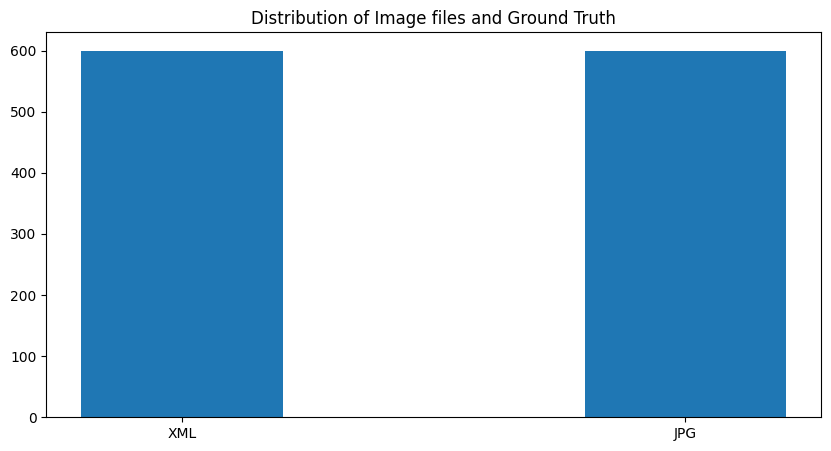

In [16]:
fig = plt.figure(figsize = (10, 5))

x = ['XML', 'JPG']
y = [len(xmls), len(jpgs)]
plt.bar(x, y,width = 0.4)
plt.title('Distribution of Image files and Ground Truth')
plt.show()

In [17]:
new_h, new_w = 1024, 1024

In [18]:
def tableplot(resultant, image_path, pathtosave):
# Define the size of the bitmap
  width, height = get_image_dimensions(image_path)

# Create a blank black image
  img = Image.new('RGB', (width, height), color='black')
  draw = ImageDraw.Draw(img)

# Define the closed areas
  closed_areas = resultant
# Draw the closed areas in white
  for area in closed_areas:
    draw.polygon(area, fill='white')

# Save the image
  img.save(pathtosave)

def colplot(resultant, image_path, pathtosave):
# Define the size of the bitmap
  width, height = get_image_dimensions(image_path)

# Create a blank black image
  img = Image.new('RGB', (width, height), color='black')
  draw = ImageDraw.Draw(img)

  for result in resultant:
  # Define the closed areas
    closed_areas = result
  # Draw the closed areas in white
    for area in closed_areas:
      draw.polygon(area, fill='white')

# Save the image
  img.save(pathtosave)

## Data Preprocessing

In [19]:
import xml.etree.ElementTree as ET

In [27]:
processed_data = []

for i, data in enumerate([jpgs]):
    
    for j, img_path in tqdm(enumerate(data)):
        
        image_name = os.path.basename(img_path)
        image = Image.open(img_path)
        w, h = image.size
        #convert to RGB image
        image = image.resize((new_h, new_w))
        if image.mode != 'RGB':
            image = image.convert("RGB")
        # table_bboxes, col_bboxes = [], []
            
        #get xml filename
        xml_file = image_name.replace('.jpg', '.xml')
        xml_path = os.path.join(ORIG_DATA_PATH, xml_file)
        xml_file.replace(" ", "")

        #processing XML
        tree = ET.parse(xml_path)
        root = tree.getroot()

        tables, all_points, max_col = getall(root)
        all_points = customsort(all_points)
        
        crds = toplot(all_points, max_col)
        print(crds, tables)
        colmask, tablemask = os.path.join(COL_MASK_PATH, image_name), os.path.join(TABLE_MASK_PATH, image_name)
        colplot(crds, img_path, colmask)
        tableplot(tables, img_path, tablemask)
        # print(xml_path, w, h)
        if j == 20:
            break

0it [00:00, ?it/s]

{(40, 0): [(1677, 3110), (1675, 3239), (1760, 3239), (1757, 3112)], (40, 1): [(1757, 3112), (1760, 3239), (2179, 3239), (2183, 3123)], (40, 2): [(2183, 3123), (2179, 3239), (2258, 3239), (2265, 3126)], (40, 3): [(2265, 3126), (2258, 3239), (2342, 3239), (2348, 3129)], (40, 4): [(2348, 3129), (2342, 3239), (2431, 3239), (2434, 3132)], (40, 5): [(2434, 3132), (2431, 3239), (2496, 3239), (2501, 3135)], (40, 6): [(2501, 3135), (2496, 3239), (2556, 3239), (2560, 3137)], (40, 7): [(2560, 3137), (2556, 3239), (2624, 3239), (2626, 3139)], (40, 8): [(2626, 3139), (2624, 3239), (2691, 3239), (2691, 3141)], (40, 9): [(2691, 3141), (2691, 3239), (2749, 3239), (2753, 3143)], (40, 10): [(2753, 3143), (2749, 3239), (2821, 3239), (2824, 3146)], (40, 11): [(2824, 3146), (2821, 3239), (2878, 3239), (2880, 3148)], (40, 12): [(2880, 3148), (2878, 3239), (2936, 3239), (2939, 3150)], (40, 13): [(2939, 3150), (2936, 3239), (3000, 3239), (3002, 3153)], (40, 14): [(3002, 3153), (3000, 3239), (3065, 3239), (306

1it [00:00,  1.61it/s]

{(41, 0): [(53, 2916), (49, 3073), (126, 3073), (129, 2918)], (41, 1): [(129, 2918), (126, 3073), (561, 3077), (566, 2936)], (41, 2): [(566, 2936), (561, 3077), (635, 3078), (640, 2939)], (41, 3): [(640, 2939), (635, 3078), (729, 3079), (734, 2943)], (41, 4): [(734, 2943), (729, 3079), (804, 3080), (808, 2947)], (41, 5): [(808, 2947), (804, 3080), (875, 3081), (880, 2951)], (41, 6): [(880, 2951), (875, 3081), (938, 3082), (943, 2954)], (41, 7): [(943, 2954), (938, 3082), (1000, 3083), (1007, 2957)], (41, 8): [(1007, 2957), (1000, 3083), (1068, 3084), (1073, 2960)], (41, 9): [(1073, 2960), (1068, 3084), (1130, 3085), (1135, 2963)], (41, 10): [(1135, 2963), (1130, 3085), (1195, 3086), (1199, 2966)], (41, 11): [(1199, 2966), (1195, 3086), (1252, 3087), (1257, 2969)], (41, 12): [(1257, 2969), (1252, 3087), (1317, 3088), (1322, 2972)], (41, 13): [(1322, 2972), (1317, 3088), (1370, 3089), (1379, 2975)], (41, 14): [(1379, 2975), (1370, 3089), (1449, 3091), (1452, 2979)], (41, 15): [(1452, 297

2it [00:01,  1.59it/s]

{(8, 0): [(132, 880), (118, 1173), (68, 3065), (154, 3066)], (8, 1): [(196, 882), (154, 3066), (578, 3071), (658, 897)], (8, 2): [(658, 897), (578, 3071), (649, 3072), (731, 900)], (8, 3): [(731, 900), (649, 3072), (730, 3074), (827, 904)], (8, 4): [(827, 904), (730, 3074), (813, 3076), (904, 907)], (8, 5): [(904, 907), (813, 3076), (900, 3078), (982, 910)], (8, 6): [(982, 910), (900, 3078), (951, 3079), (1036, 912)], (8, 7): [(1036, 912), (951, 3079), (1012, 3080), (1112, 915)], (8, 8): [(1112, 915), (1012, 3080), (1072, 3081), (1161, 917)], (8, 9): [(1161, 917), (1072, 3081), (1148, 3083), (1238, 920)], (8, 10): [(1238, 920), (1148, 3083), (1208, 3084), (1297, 923)], (8, 11): [(1297, 923), (1208, 3084), (1266, 3085), (1356, 926)], (8, 12): [(1356, 926), (1266, 3085), (1327, 3087), (1429, 929)], (8, 13): [(1429, 929), (1327, 3087), (1385, 3089), (1485, 932)], (8, 14): [(1485, 932), (1385, 3089), (1456, 3091), (1547, 935)], (8, 15): [(1547, 935), (1456, 3091), (1509, 3092), (1608, 938)

3it [00:02,  1.39it/s]

{(37, 0): [(30, 2629), (13, 2780), (117, 2792), (134, 2640)], (37, 1): [(134, 2640), (117, 2792), (473, 2833), (490, 2679)], (37, 2): [(490, 2679), (473, 2833), (569, 2844), (581, 2690)], (37, 3): [(581, 2690), (569, 2844), (664, 2855), (680, 2702)], (37, 4): [(680, 2702), (664, 2855), (751, 2866), (768, 2712)], (37, 5): [(768, 2712), (751, 2866), (846, 2878), (863, 2723)], (37, 6): [(863, 2723), (846, 2878), (917, 2887), (936, 2732)], (37, 7): [(936, 2732), (917, 2887), (996, 2897), (1013, 2741)], (37, 8): [(1013, 2741), (996, 2897), (1067, 2906), (1087, 2750)], (37, 9): [(1087, 2750), (1067, 2906), (1136, 2915), (1155, 2758)], (37, 10): [(1155, 2758), (1136, 2915), (1222, 2926), (1242, 2768)], (37, 11): [(1242, 2768), (1222, 2926), (1296, 2935), (1315, 2777)], (37, 12): [(1315, 2777), (1296, 2935), (1358, 2943), (1377, 2785)], (37, 13): [(1377, 2785), (1358, 2943), (1416, 2950), (1435, 2792)], (37, 14): [(1435, 2792), (1416, 2950), (1474, 2957), (1493, 2799)], (37, 15): [(1493, 2799)

4it [00:02,  1.57it/s]

{(29, 0): [(79, 2682), (65, 3064), (165, 3064), (179, 2684)], (29, 1): [(179, 2684), (165, 3064), (513, 3068), (521, 2695)], (29, 2): [(521, 2695), (513, 3068), (611, 3069), (623, 2698)], (29, 3): [(623, 2698), (611, 3069), (707, 3070), (717, 2701)], (29, 4): [(717, 2701), (707, 3070), (800, 3072), (806, 2704)], (29, 5): [(806, 2704), (800, 3072), (885, 3074), (892, 2707)], (29, 6): [(892, 2707), (885, 3074), (959, 3075), (976, 2710)], (29, 7): [(976, 2710), (959, 3075), (1039, 3077), (1053, 2713)], (29, 8): [(1053, 2713), (1039, 3077), (1109, 3078), (1128, 2716)], (29, 9): [(1128, 2716), (1109, 3078), (1183, 3079), (1192, 2719)], (29, 10): [(1192, 2719), (1183, 3079), (1261, 3081), (1278, 2722)], (29, 11): [(1278, 2722), (1261, 3081), (1337, 3083), (1346, 2725)], (29, 12): [(1346, 2725), (1337, 3083), (1403, 3084), (1420, 2728)], (29, 13): [(1420, 2728), (1403, 3084), (1463, 3085), (1478, 2731)], (29, 14): [(1478, 2731), (1463, 3085), (1527, 3086), (1537, 2734)], (29, 15): [(1537, 273

5it [00:03,  1.71it/s]

{(20, 0): [(841, 2954), (835, 3179), (964, 3181), (972, 2957)], (20, 1): [(972, 2957), (964, 3181), (1503, 3193), (1508, 2971)], (20, 2): [(1508, 2971), (1503, 3193), (1680, 3197), (1689, 2976)], (20, 3): [(1689, 2976), (1680, 3197), (1953, 3203), (1956, 2984)], (20, 4): [(1956, 2984), (1953, 3203), (2459, 3214), (2464, 2998)], (20, 5): [(2464, 2998), (2459, 3214), (2643, 3218), (2650, 3004)], (20, 6): [(2650, 3004), (2643, 3218), (2906, 3224), (2910, 3012)], (20, 7): [(2910, 3012), (2906, 3224), (3446, 3236), (3446, 3028)], (20, 8): [(3446, 3028), (3446, 3236), (3628, 3241), (3636, 3034)], (20, 9): [(3636, 3034), (3628, 3241), (3897, 3248), (3903, 3042)], (20, 10): [(3903, 3042), (3897, 3248), (4452, 3261), (4455, 3059)]}
{(0, 0): None, (0, 1): None, (0, 2): None, (0, 3): None, (0, 4): None, (0, 5): None, (0, 6): None, (0, 7): None, (0, 8): None, (0, 9): None, (0, 10): None}
11 11 11
j: 0 R1: 20 [(841, 2954), (835, 3179), (964, 3181), (972, 2957)]
j: 0 R1: 20 [(972, 2957), (964, 3181)

6it [00:03,  1.51it/s]

{(20, 0): [(650, 2915), (644, 3062), (793, 3067), (799, 2919)], (20, 1): [(799, 2919), (793, 3067), (1325, 3087), (1325, 2936)], (20, 2): [(1325, 2936), (1325, 3087), (1512, 3094), (1519, 2943)], (20, 3): [(1519, 2943), (1512, 3094), (1783, 3104), (1788, 2952)], (20, 4): [(1788, 2952), (1783, 3104), (2289, 3124), (2297, 2969)], (20, 5): [(2297, 2969), (2289, 3124), (2480, 3132), (2486, 2976)], (20, 6): [(2486, 2976), (2480, 3132), (2743, 3143), (2747, 2985)], (20, 7): [(2747, 2985), (2743, 3143), (3265, 3164), (3270, 3003)], (20, 8): [(3270, 3003), (3265, 3164), (3455, 3172), (3460, 3010)], (20, 9): [(3460, 3010), (3455, 3172), (3718, 3183), (3723, 3019)], (20, 10): [(3723, 3019), (3718, 3183), (4276, 3206), (4280, 3039)]}
{(0, 0): None, (0, 1): None, (0, 2): None, (0, 3): None, (0, 4): None, (0, 5): None, (0, 6): None, (0, 7): None, (0, 8): None, (0, 9): None, (0, 10): None}
11 11 11
j: 0 R1: 20 [(650, 2915), (644, 3062), (793, 3067), (799, 2919)]
j: 0 R1: 20 [(799, 2919), (793, 3067)

7it [00:04,  1.60it/s]

{(18, 0): [(691, 2957), (688, 3149), (822, 3149), (829, 2959)], (18, 1): [(829, 2959), (822, 3149), (1359, 3152), (1358, 2969)], (18, 2): [(1358, 2969), (1359, 3152), (1542, 3153), (1545, 2973)], (18, 3): [(1545, 2973), (1542, 3153), (1808, 3155), (1810, 2978)], (18, 4): [(1810, 2978), (1808, 3155), (2328, 3159), (2328, 2989)], (18, 5): [(2328, 2989), (2328, 3159), (2516, 3161), (2518, 2993)], (18, 6): [(2518, 2993), (2516, 3161), (2784, 3163), (2783, 2999)], (18, 7): [(2783, 2999), (2784, 3163), (3318, 3167), (3319, 3010)], (18, 8): [(3319, 3010), (3318, 3167), (3515, 3169), (3515, 3015)], (18, 9): [(3515, 3015), (3515, 3169), (3781, 3171), (3782, 3021)], (18, 10): [(3782, 3021), (3781, 3171), (4335, 3175), (4334, 3033)]}
{(0, 0): None, (0, 1): None, (0, 2): None, (0, 3): None, (0, 4): None, (0, 5): None, (0, 6): None, (0, 7): None, (0, 8): None, (0, 9): None, (0, 10): None}
11 11 11
j: 0 R1: 18 [(691, 2957), (688, 3149), (822, 3149), (829, 2959)]
j: 0 R1: 18 [(829, 2959), (822, 3149)

8it [00:04,  1.80it/s]

{(20, 0): [(649, 2952), (643, 3151), (774, 3152), (780, 2955)], (20, 1): [(780, 2955), (774, 3152), (1319, 3158), (1324, 2968)], (20, 2): [(1324, 2968), (1319, 3158), (1506, 3161), (1510, 2973)], (20, 3): [(1510, 2973), (1506, 3161), (1771, 3165), (1775, 2980)], (20, 4): [(1775, 2980), (1771, 3165), (2284, 3172), (2288, 2994)], (20, 5): [(2288, 2994), (2284, 3172), (2470, 3175), (2473, 2999)], (20, 6): [(2473, 2999), (2470, 3175), (2735, 3179), (2738, 3006)], (20, 7): [(2738, 3006), (2735, 3179), (3272, 3187), (3275, 3021)], (20, 8): [(3275, 3021), (3272, 3187), (3458, 3190), (3460, 3026)], (20, 9): [(3460, 3026), (3458, 3190), (3730, 3194), (3731, 3034)], (20, 10): [(3731, 3034), (3730, 3194), (4298, 3202), (4298, 3050)]}
{(0, 0): None, (0, 1): None, (0, 2): None, (0, 3): None, (0, 4): None, (0, 5): None, (0, 6): None, (0, 7): None, (0, 8): None, (0, 9): None, (0, 10): None}
11 11 11
j: 0 R1: 20 [(649, 2952), (643, 3151), (774, 3152), (780, 2955)]
j: 0 R1: 20 [(780, 2955), (774, 3152)

9it [00:05,  1.92it/s]

{(12, 0): [(715, 2849), (717, 3147), (848, 3142), (844, 2846)], (12, 1): [(844, 2846), (848, 3142), (1374, 3127), (1372, 2835)], (12, 2): [(1372, 2835), (1374, 3127), (1566, 3122), (1562, 2832)], (12, 3): [(1562, 2832), (1566, 3122), (1825, 3115), (1823, 2827)], (12, 4): [(1823, 2827), (1825, 3115), (2332, 3101), (2329, 2817)], (12, 5): [(2329, 2817), (2332, 3101), (2528, 3096), (2521, 2814)], (12, 6): [(2521, 2814), (2528, 3096), (2794, 3089), (2786, 2810)], (12, 7): [(2786, 2810), (2794, 3089), (3328, 3075), (3327, 2801)], (12, 8): [(3327, 2801), (3328, 3075), (3517, 3070), (3517, 2798)], (12, 9): [(3517, 2798), (3517, 3070), (3791, 3063), (3786, 2794)], (12, 10): [(3786, 2794), (3791, 3063), (4352, 3048), (4343, 2785)]}
{(0, 0): None, (0, 1): None, (0, 2): None, (0, 3): None, (0, 4): None, (0, 5): None, (0, 6): None, (0, 7): None, (0, 8): None, (0, 9): None, (0, 10): None}
11 11 11
j: 0 R1: 12 [(715, 2849), (717, 3147), (848, 3142), (844, 2846)]
j: 0 R1: 12 [(844, 2846), (848, 3142)

10it [00:05,  1.98it/s]

{(27, 0): [(2477, 3196), (2477, 3380), (2598, 3380), (2596, 3196)], (27, 1): [(2596, 3196), (2598, 3380), (3024, 3380), (3020, 3200)], (27, 2): [(3020, 3200), (3024, 3380), (3134, 3380), (3140, 3202)], (27, 3): [(3140, 3202), (3134, 3380), (3252, 3380), (3250, 3203)], (27, 4): [(3250, 3203), (3252, 3380), (3356, 3380), (3356, 3204)], (27, 5): [(3356, 3204), (3356, 3380), (3468, 3380), (3468, 3206)], (27, 6): [(3468, 3206), (3468, 3380), (3559, 3380), (3557, 3207)], (27, 7): [(3557, 3207), (3559, 3380), (3663, 3380), (3652, 3209)], (27, 8): [(3652, 3209), (3663, 3380), (3731, 3380), (3730, 3210)], (27, 9): [(3730, 3210), (3731, 3380), (3819, 3380), (3819, 3212)], (27, 10): [(3819, 3212), (3819, 3380), (3911, 3380), (3913, 3214)], (27, 11): [(3913, 3214), (3911, 3380), (3999, 3380), (4000, 3216)], (27, 12): [(4000, 3216), (3999, 3380), (4071, 3380), (4075, 3217)], (27, 13): [(4075, 3217), (4071, 3380), (4146, 3380), (4146, 3218)], (27, 14): [(4146, 3218), (4146, 3380), (4214, 3380), (421

11it [00:06,  2.03it/s]

{(6, 0): [(52, 2700), (52, 3373), (278, 3369), (279, 2701)], (6, 1): [(279, 2701), (278, 3369), (549, 3372), (550, 2703)], (6, 2): [(550, 2703), (549, 3372), (762, 3371), (765, 2705)], (6, 3): [(765, 2705), (762, 3371), (1027, 3374), (1027, 2707)], (6, 4): [(1027, 2707), (1027, 3374), (1363, 3374), (1364, 2710)], (6, 5): [(1364, 2710), (1363, 3374), (1635, 3374), (1635, 2712)], (6, 6): [(1635, 2712), (1635, 3374), (1846, 3372), (1846, 2714)], (6, 7): [(1846, 2714), (1846, 3372), (2191, 3373), (2191, 2717)], (6, 8): [(2191, 2717), (2191, 3373), (2426, 3376), (2421, 2722)], (6, 9): [(2421, 2722), (2426, 3376), (2712, 3376), (2705, 2728)], (6, 10): [(2705, 2728), (2712, 3376), (2971, 3379), (2974, 2735)], (6, 11): [(2974, 2735), (2971, 3379), (3246, 3380), (3243, 2740)], (6, 12): [(3243, 2740), (3246, 3380), (3459, 3379), (3454, 2745)], (6, 13): [(3454, 2745), (3459, 3379), (3681, 3381), (3675, 2749)], (6, 14): [(3675, 2749), (3681, 3381), (3964, 3384), (3958, 2751)], (6, 15): [(3958, 275

12it [00:06,  1.87it/s]

{(3, 0): [(173, 2802), (166, 3814), (651, 3814), (669, 2791)], (3, 1): [(669, 2791), (651, 3814), (988, 3814), (1012, 2784)], (3, 2): [(1012, 2784), (988, 3814), (1205, 3814), (1228, 2778)], (3, 3): [(1228, 2778), (1205, 3814), (1452, 3814), (1470, 2774)], (3, 4): [(1470, 2774), (1452, 3814), (1704, 3814), (1733, 2765)], (3, 5): [(1733, 2765), (1704, 3814), (1969, 3814), (1982, 2760)], (3, 6): [(1982, 2760), (1969, 3814), (2187, 3814), (2201, 2757)], (3, 7): [(2201, 2757), (2187, 3814), (2561, 3811), (2571, 2756)], (3, 8): [(2571, 2756), (2561, 3811), (3072, 3814), (3075, 2760)], (3, 9): [(3075, 2760), (3072, 3814), (3313, 3814), (3308, 2766)], (3, 10): [(3308, 2766), (3313, 3814), (3527, 3814), (3525, 2770)], (3, 11): [(3525, 2770), (3527, 3814), (3757, 3814), (3756, 2770)], (3, 12): [(3756, 2770), (3757, 3814), (3991, 3814), (3992, 2776)], (3, 13): [(3992, 2776), (3991, 3814), (4231, 3814), (4230, 2780)], (3, 14): [(4230, 2780), (4231, 3814), (4474, 3814), (4468, 2782)], (3, 15): [(4

13it [00:08,  1.55it/s]

{(9, 0): [(116, 3107), (109, 3407), (281, 3408), (283, 3108)], (9, 1): [(283, 3108), (281, 3408), (579, 3410), (585, 3109)], (9, 2): [(585, 3109), (579, 3410), (774, 3411), (778, 3108)], (9, 3): [(778, 3108), (774, 3411), (1063, 3106), (971, 3110)], (9, 4): [(1063, 3106), (1058, 3413), (1399, 3416), (1399, 3109)], (9, 5): [(1399, 3109), (1399, 3416), (1678, 3417), (1679, 3111)], (9, 6): [(1679, 3111), (1678, 3417), (1882, 3418), (1883, 3112)], (9, 7): [(1883, 3112), (1882, 3418), (2114, 3419), (2115, 3112)], (9, 8): [(2115, 3112), (2114, 3419), (2302, 3420), (2302, 3112)], (9, 9): None, (9, 10): [(2504, 3111), (2503, 3421), (2769, 3422), (2768, 3113)], (9, 11): [(2768, 3113), (2769, 3422), (3057, 3425), (3062, 3112)], (9, 12): [(3062, 3112), (3057, 3425), (3365, 3428), (3369, 3116)], (9, 13): [(3369, 3116), (3365, 3428), (3582, 3431), (3586, 3119)], (9, 14): [(3586, 3119), (3582, 3431), (3793, 3432), (3794, 3120)], (9, 15): [(3794, 3120), (3793, 3432), (4118, 3437), (4122, 3126)], (9, 

KeyError: (-1, 9)

In [ ]:
processed_data.to_csv("processed_data.csv", index = False)

In [ ]:
processed_data.head()

In [ ]:
processed_data = pd.read_csv('processed_data.csv')

In [ ]:
processed_data.head()

## Advanced EDA

In [ ]:
processed_data['hasTable'].value_counts().tolist()

#### Positive : Negative Ratio

In [ ]:
fig = plt.figure(figsize = (10, 5))

x = ['Neg Samples', 'Pos Samples']
data = processed_data['hasTable'].value_counts().tolist()
y = [data[1],data[0]]
plt.bar(x, y,width = 0.4)
plt.title('Distribution of Positive and Negative Samples')
plt.show()

#### Columns without any Table

In [ ]:
processed_data[(processed_data['table_count']==0)]

#### Table with No Columns

In [ ]:
processed_data[(processed_data['hasTable']==1) & (processed_data['col_count']==0)]

#### plotting image with table but no columns

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.1.2010_5.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.1.2107_9.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.160.669_3.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.7.2174_3.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.7.2174_8.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

### Observations

- There are 5 images with tables but no columns
- There are total 494 Negative Samples and 499 Positive Samples.
- Also, we confirmed that there are no columns with only tables.

### Height of the Image

In [ ]:
processed_data['original_height'].plot.hist(bins = 10)

In [ ]:
sns.kdeplot(processed_data['original_height'], color='b', fill=True)
  
plt.xlabel('Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Image

In [ ]:
processed_data['original_width'].plot.hist(bins = 10)

In [ ]:
sns.kdeplot(processed_data['original_width'], color='b', fill=True)

plt.xlabel('Width')
plt.ylabel('Probability Density')
plt.show()

### Total Tables

In [ ]:
processed_data['table_count'].value_counts().plot.bar()
plt.xlabel('Tables')
plt.ylabel('Count')
plt.show()

### Total Columns

In [ ]:
processed_data['col_count'].value_counts().plot.bar()
plt.xlabel('Columns')
plt.ylabel('Count')
plt.show()

In [ ]:
import json


### Observations

- Height of most images are between 1000 - 1100
- Width of most images are between 700-800.
- Apart from images with no Tables, most images contains only 1 table and at maximum 4 tables.
- Total Columns in an image (can have multiple tables in a page) ranges from 4 - 42
- We have also seen Image with no columns but have Tables in them.

### Height of Table

In [ ]:
heights = []
widths = []
for boxes in processed_data[processed_data['hasTable']==1]['table_bboxes']:
    # boxes = [json.loads('[' + boxes.strip('][').strip(',') + ']')]
    print(boxes)
# Convert the cleaned string to a Python list
# array = json.loads('[' + cleaned_string + ']')
    # for box in boxes:
    #     heights.append(box[3]-box[1])
    #     widths.append(box[2]-box[0])

In [ ]:
min(col_widths)

In [ ]:
sns.histplot(heights, color='b', Label='Table Height')

plt.xlabel('Table Height')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(heights, color='b', shade=True, Label='Table Height')

plt.xlabel('Table Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Table

In [ ]:
sns.histplot(widths, color='b', Label='Table Width')

plt.xlabel('Table Width')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(widths, color='b', shade=True, Label='Table Width')

plt.xlabel('Table Width')
plt.ylabel('Probability Density')
plt.show()

### Height of the Column

In [ ]:
col_heights = []
col_widths = []
for boxes in processed_data[processed_data['hasTable']==1]['col_bboxes']:
    for box in boxes:
        col_heights.append(box[3]-box[1])
        col_widths.append(box[2]-box[0])

In [ ]:
sns.histplot(col_heights, color='b', Label='Column Height')

plt.xlabel('Column Height')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(col_heights, color='b', shade=True, Label='Column Height')

plt.xlabel('Column Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Column

In [ ]:
sns.histplot(col_widths, color='b', Label='Column Width')

plt.xlabel('Column Width')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(col_widths, color='b', shade=True, Label='Table Column')

plt.xlabel('Table Column')
plt.ylabel('Probability Density')
plt.show()

### Observations

- Height of tables ranges from 30 - 870, but most are between  50-300.
- Width of tables ranges from 50 - 900, but common width is 400.
- Height of columns ranges from 10 - 880 showing a right skewed distribution
- Width of columns ranges from 7 - 671 showing a right skewed distribution